In [22]:
import os
import torch

from dotenv import load_dotenv

load_dotenv()

from transformers import (
    BitsAndBytesConfig,
    LlavaProcessor,
    LlavaForConditionalGeneration,
)

from utils import extract_frames, show_frame, convert_frame_to_bytes

# Quantize model for lower storage
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load model
model_id = "llava-hf/llava-interleave-qwen-0.5b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.float16,
    quantization_config=quantization_config,
)

# Load Prompt processor
processor = LlavaProcessor.from_pretrained(model_id)

In [23]:
video_path = os.path.abspath('../public/video_rua01.mp4')
frames, ts = extract_frames(video_path)

In [24]:
frames[:5]

[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  8,  10,   7],
         [  3,   5,   2],
         [  2,   4,   1]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  8,  10,   7],
         [  3,   5,   2],
         [  2,   4,   1]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  8,  10,   7],
         [  3,   5,   2],
         [  2,   4,   1]],
 
        ...,
 
        [[  8,  10,   7],
         [  8,  10,   7],
         [  8,  10,   7],
         ...,
         [ 52,  52,  52],
         [ 52,  52,  52],
         [ 52,  52,  52]],
 
        [[ 20,  22,  19],
         [ 17,  19,  16],
         [ 11,  13,  10],
         ...,
         [ 52,  52,  52],
         [ 52,  52,  52],
         [ 52,  52,  52]],
 
        [[102, 104, 101],
         [ 98, 100,  97],
         [ 89,  91,  88],
         ...,
         [ 52,  52,  52],
  

In [25]:
ts

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [30]:
expected_response_format = (
    "Return ONLY JSON in the following format:\n"
    "{\"matches\": [{\"exists\": boolean, \"description\": string}]}\n"
    "- \"exists\" MUST strictly reflect if the target object is visible.\n"
    "- \"description\" MUST describe ALL visible objects in the frame.\n"
    "- Do NOT assume, guess, or infer anything not visible.\n"
    "- If the target is not present, \"exists\" must be false.\n"
)

target = "people crossing the street"

user_prompt = (
    f"{expected_response_format}\n"
    f"Target object: \"{target}\"\n"
    f"First, analyze the image neutrally.\n"
    f"Then answer strictly based on visible evidence.\n"
)

frame = frames[8]

prompt = (
    f"<|im_start|>user\n"
    f"<image>\n"
    f"{user_prompt}\n"
    f"<|im_end|>\n"
    f"<|im_start|>assistant\n"
)

inputs = processor(text=prompt, images=frame, return_tensors="pt").to(
    model.device, model.dtype
)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)

# MODEL DESCRIBES WELL THE IMAGE, HOWEVER IT IS STILL BIASED BY THE USER PROMPT (WONT DETECT EVERYTHING I EXPECTED ON THE IMAGE)
response = processor.decode(output[0], skip_special_tokens=True)
response

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


'user\n\nReturn ONLY JSON in the following format:\n{"matches": [{"exists": boolean, "description": string}]}\n- "exists" MUST strictly reflect if the target object is visible.\n- "description" MUST describe ALL visible objects in the frame.\n- Do NOT assume, guess, or infer anything not visible.\n- If the target is not present, "exists" must be false.\n\nTarget object: "people crossing the street"\nFirst, analyze the image neutrally.\nThen answer strictly based on visible evidence.\n\n\nassistant\n{"matches": [{"exists": true, "description": "A man walking across a street in New York City.", "exists": true, "image": "image"}]}'

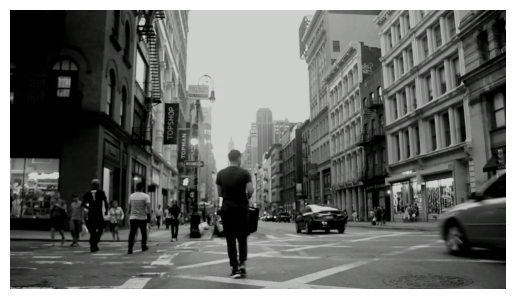

In [27]:
show_frame(frame)

In [ ]:
convert_frame_to_bytes(frame)

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x048\x07\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98